In [1]:
import keras
import keras.backend as K
import tensorflow as tf 
import seaborn as sns
import cv2
import numpy as np 
import pandas as pd
from models import matting_net
from data_generator import *
from metrics import * 
import matplotlib.pyplot as plt

# the metric
def iou_coef(y_true, y_pred, smooth=1):
    
    threshold = tf.constant(0.5, dtype=tf.float64)
    
    y_true = tf.cast(y_true > threshold, dtype=tf.float64)
    y_pred = tf.cast(y_pred > threshold, dtype=tf.float64)
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    
    return iou

Using TensorFlow backend.
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
# model path for using in EDA
MODEL_PATH = "./trained_models/mattingnet/withBlankAndCustom/849-0.05.h5"
IMG_PATHS = "./dataset/img_paths.npy"

In [3]:
img_paths = np.load(IMG_PATHS)
img_paths[:2]

array(['./dataset/selfie/testing/00001.png',
       './dataset/selfie/testing/00002.png'], dtype='<U35')

In [4]:
# test and store ious
# model = matting_net((256,256,3), train=False)
model = matting_net((256,256,3), train=False)
model.load_weights(MODEL_PATH)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 256, 256, 8)  144         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 256, 256, 8)  0           separable_conv2d_1[0][0]         
___________________________________________________________________________________________

In [5]:
import numpy as np 
import cv2
# import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/training/00694.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
# img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:] / 255.
img = img.astype(np.float32)
img = img[np.newaxis,:,:,:] / 255.

mask = cv2.imread("./dataset/selfie/training/00694_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))


pred = model.predict(img)

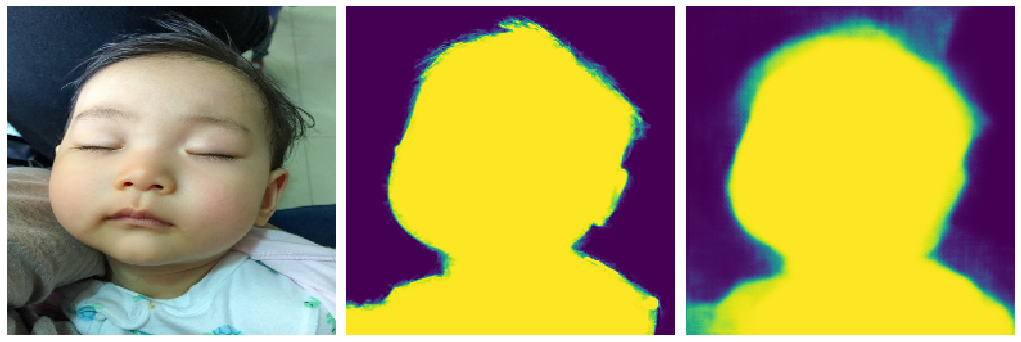

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(19,7))
plt.subplot(141)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(142)
plt.imshow(mask)
plt.axis("off")

plt.subplot(143)
plt.imshow(pred.squeeze(0).squeeze(-1))
plt.axis("off")

# plt.subplot(144)
# plt.imshow(pred[1].squeeze(0).squeeze(-1))
# plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
import numpy as np 
import cv2
# import matplotlib.pyplot as plt

img_ = cv2.imread("./photo_2019-12-24 15.25.05.jpeg", cv2.IMREAD_COLOR)
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
sap = img_.shape
img = cv2.resize(img_, (256,256))
img = img.astype(np.float32)
img = img[np.newaxis,:,:,:] / 255.

pred = model.predict(img)

In [2]:
trues_ = tf.constant(img , dtype=tf.float64)
preds_ = tf.constant(pred[0], dtype=tf.float64) 

iou = iou_coef(trues_, preds_, smooth=1)

with tf.Session()  as sess :
    iou_ = sess.run(iou)
    print(iou_)

NameError: name 'tf' is not defined

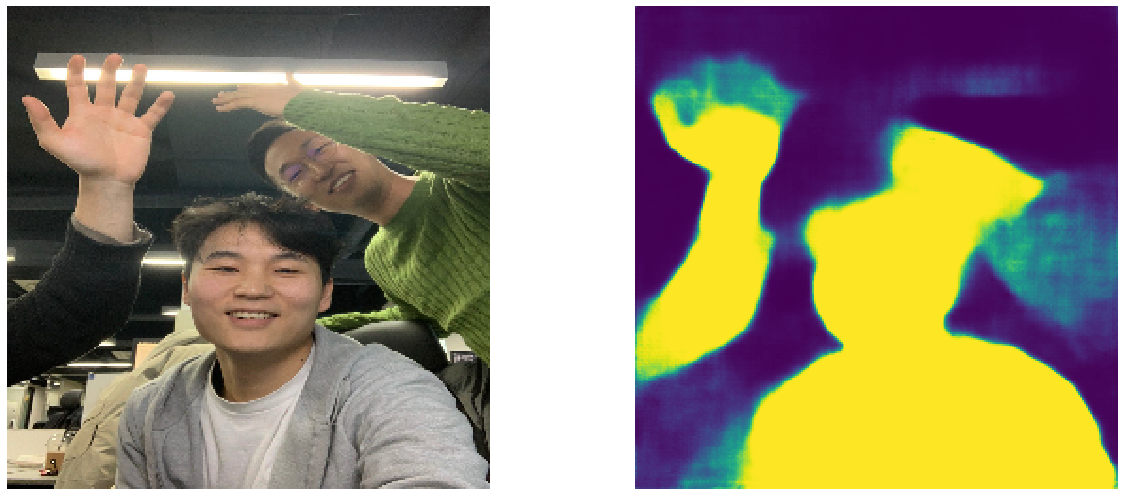

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(pred.squeeze(0).squeeze(-1))
plt.axis("off")

plt.tight_layout()
plt.show()

In [22]:
sap[0]

1278

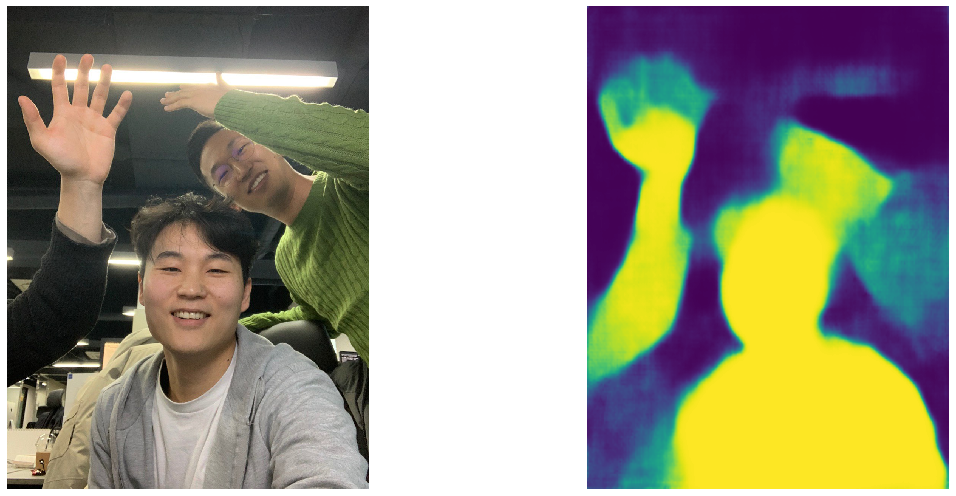

In [25]:
plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img_[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(cv2.resize(pred[0].squeeze(0).squeeze(-1), (sap[1], sap[0])))
plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
# data feeding logic
test_params = {
            'dim': (256,256),
            'batch_size': 1,
            'n_channels': 3,
            'shuffle': False,
            'augment': False,
            'train' : False,
        }

gen = DataGeneratorMatting(img_paths, **test_params)

In [10]:
iou_list = []
for ge in gen:
    g, l = ge
    preds = model.predict(g, verbose=1)
    trues_ = tf.constant(l[0] , dtype=tf.float64)
    preds_ = tf.constant(preds, dtype=tf.float64) 

    iou = iou_coef(trues_, preds_, smooth=1)
    
    with tf.Session()  as sess :
        iou_ = sess.run(iou)
        print(iou_)
        iou_list.append(iou_)



1/1 [==============================] - 0s 72ms/step
0.9858081194439315
1/1 [==============================] - 0s 70ms/step
0.989373880151304
1/1 [==============================] - 0s 77ms/step
0.98179629466514
1/1 [==============================] - 0s 79ms/step
0.9869429894481135
1/1 [==============================] - 0s 70ms/step
0.9841999103541013
1/1 [==============================] - 0s 75ms/step
0.975056186010377
1/1 [==============================] - 0s 71ms/step
0.9742067853740749
1/1 [==============================] - 0s 70ms/step
0.9691385591726407
1/1 [==============================] - 0s 71ms/step
0.9854549641171279
1/1 [==============================] - 0s 70ms/step
0.9759785392025363
1/1 [==============================] - 0s 70ms/step
0.9835085085085085
1/1 [==============================] - 0s 69ms/step
0.9925268928423666
1/1 [==============================] - 0s 71ms/step
0.9549003299975853
1/1 [==============================] - 0s 69ms/step
0.99018229639035
1/1 [=======

0.9891427445959919
1/1 [==============================] - 0s 68ms/step
0.9905963802878325
1/1 [==============================] - 0s 70ms/step
0.977983664512983
1/1 [==============================] - 0s 69ms/step
0.9791787961961795
1/1 [==============================] - 0s 67ms/step
0.9725684651078155
1/1 [==============================] - 0s 69ms/step
0.9783892200344643
1/1 [==============================] - 0s 68ms/step
0.9813664596273292
1/1 [==============================] - 0s 70ms/step
0.9910899018888073
1/1 [==============================] - 0s 69ms/step
0.984283357771261
1/1 [==============================] - 0s 70ms/step
0.9816335873751111
1/1 [==============================] - 0s 69ms/step
0.9803057649431999
1/1 [==============================] - 0s 70ms/step
0.9547886203396341
1/1 [==============================] - 0s 70ms/step
0.9799507389162562
1/1 [==============================] - 0s 70ms/step
0.9925955951898392
1/1 [==============================] - 0s 68ms/step
0.983556

0.9830106330003808
1/1 [==============================] - 0s 69ms/step
0.977306443205966
1/1 [==============================] - 0s 68ms/step
0.9722032575831464
1/1 [==============================] - 0s 69ms/step
0.9836222869242985
1/1 [==============================] - 0s 69ms/step
0.9484755783178084
1/1 [==============================] - 0s 69ms/step
0.9874148344292047
1/1 [==============================] - 0s 70ms/step
0.9728476600286867
1/1 [==============================] - 0s 70ms/step
0.9856494096276113
1/1 [==============================] - 0s 70ms/step
0.9773348252621717
1/1 [==============================] - 0s 69ms/step
0.9652869031975471
1/1 [==============================] - 0s 71ms/step
0.9567077774981123
1/1 [==============================] - 0s 70ms/step
0.9859011381009003
1/1 [==============================] - 0s 71ms/step
0.9873504453697359
1/1 [==============================] - 0s 70ms/step
0.9668498022666349
1/1 [==============================] - 0s 71ms/step
0.98603

0.9645187825610091
1/1 [==============================] - 0s 78ms/step
0.9728162682240242
1/1 [==============================] - 0s 72ms/step
0.973446263019343
1/1 [==============================] - 0s 80ms/step
0.9885291005291005
1/1 [==============================] - 0s 71ms/step
0.9860091143943572
1/1 [==============================] - 0s 75ms/step
0.9637668387259222
1/1 [==============================] - 0s 72ms/step
0.9838673071831145
1/1 [==============================] - 0s 72ms/step
0.9757882313269263
1/1 [==============================] - 0s 74ms/step
0.9774833817058328
1/1 [==============================] - 0s 71ms/step
0.9898731825149811
1/1 [==============================] - 0s 70ms/step
0.9702434625788999
1/1 [==============================] - 0s 82ms/step
0.9767122031722747
1/1 [==============================] - 0s 72ms/step
0.9773860398860399
1/1 [==============================] - 0s 83ms/step
0.9773693673125767
1/1 [==============================] - 0s 76ms/step
0.98662

0.9853320850001419
1/1 [==============================] - 0s 68ms/step
0.9712072155411656
1/1 [==============================] - 0s 71ms/step
0.9840532902704885
1/1 [==============================] - 0s 72ms/step
0.9852541596702793
1/1 [==============================] - 0s 69ms/step
0.9699172218857258
1/1 [==============================] - 0s 68ms/step
0.9751076853321242
1/1 [==============================] - 0s 68ms/step
0.9808908803373748
1/1 [==============================] - 0s 70ms/step
0.9785022338213828
1/1 [==============================] - 0s 68ms/step
0.9883975763826222
1/1 [==============================] - 0s 68ms/step
0.9837338262476895
1/1 [==============================] - 0s 68ms/step
0.986740672217083
1/1 [==============================] - 0s 70ms/step
0.9798019894456639
1/1 [==============================] - 0s 69ms/step
0.9907902626214175
1/1 [==============================] - 0s 69ms/step
0.9887420460107684
1/1 [==============================] - 0s 70ms/step
0.98664

KeyboardInterrupt: 

In [ ]:
len(iou_list)

In [ ]:
sns.distplot(iou_list)